---
# PREPROCESS RAW DATA

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import gc

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_time_series_generation

import numpy as np
import pandas as pd

%matplotlib inline  

---
# 1. Read data from the `demographics` csv file

In [2]:
#set the data directory
data_dir = os.path.abspath('../01_raw_data')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_DEMOGRAPHICS.csv'

#read data and show some info
df = utils.read_csv(data_file)

print(df.shape[0])

df.head()

11675


,subject_id,Demographics_Delta,Age,Date_of_Birth,Ethnicity,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,Sex
0,89,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
1,329,0.0,38.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Female
2,348,0.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Female
3,406,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male
4,411,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male


## Show columns stats and missingness

In [3]:
utils.show_columns_stats(df)

subject_id...................... = 11675 rows (100.0%)     0 with NaN (  0.0%) Uniques= 11675 
Demographics_Delta.............. = 11590 rows (99.27%)    85 with NaN ( 0.73%) Uniques=    12 
Age............................. =  8654 rows (74.12%)  3021 with NaN (25.88%) Uniques=   195 
Date_of_Birth................... =  1298 rows (11.12%) 10377 with NaN (88.88%) Uniques=  1235 
Ethnicity....................... =  2936 rows (25.15%)  8739 with NaN (74.85%) Uniques=     4 
Race_Americ_Indian_Alaska_Native =    12 rows (  0.1%) 11663 with NaN ( 99.9%) Uniques=     2 
Race_Asian...................... =    73 rows ( 0.63%) 11602 with NaN (99.37%) Uniques=     2 
Race_Black_African_American..... =   136 rows ( 1.16%) 11539 with NaN (98.84%) Uniques=     2 
Race_Hawaiian_Pacific_Islander.. =     1 rows ( 0.01%) 11674 with NaN (99.99%) Uniques=     2 
Race_Unknown.................... =    25 rows ( 0.21%) 11650 with NaN (99.79%) Uniques=     2 
Race_Caucasian.................. =  7581 rows (64.

## Calculate the Age for those samples having `Age=NaN` and `Date_of_Birth<>NaN`
### Calculation based on delta days in Date_of_Birth column

In [4]:
#get samples with Age=NaN and Date_of_Birth<>NaN
df_calc_age_from_birth = df.loc[(df.Age.isnull()) & (df.Date_of_Birth.isnull()==False)]
print(f'Age calculated for {utils.get_quantity_of_rows(df_calc_age_from_birth)} samples')

#calculate the Age from the Date_of_Birth delta (in days and negative)
ages_calculated = df_calc_age_from_birth.Date_of_Birth.apply( lambda x: utils.calculate_age_from_birth_delta(np.abs(x)) )

#update samples with the calculated Age
df.loc[df_calc_age_from_birth.index,'Age'] = ages_calculated



Age calculated for 944 samples


##### We can note that now the Age column has 82.21% of non-NaN values (previously had 74.12%) 

In [5]:
utils.show_columns_stats(df, ['Age'])

Age =  9598 rows (82.21%)  2077 with NaN (17.79%) Uniques=   195 


### Remove irrelevant columns for this study, which are:
- `Demographics_Delta` column
- `Date_of_Birth` column (not necessary, using `Age` column), 
- `Ethnicity` column (high number of missing values)
- All `Race_*` columns (high number of missing values)

In [6]:
irrelevant_cols = ['Demographics_Delta', 'Date_of_Birth', 'Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
                   'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander', 'Race_Unknown', 'Race_Caucasian', 
                   'Race_Other', 'Race_Other_Specify']

df.drop(columns=irrelevant_cols, inplace=True)
df.head()

,subject_id,Age,Sex
0,89,NaN,Male
1,329,38.0,Female
2,348,52.0,Female
3,406,NaN,Male
4,411,NaN,Male


----
----
----
## Remove rows with NaN in the AGE and SEX columns

In [7]:
# AGE column
to_delete = df.loc[(df.Age.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete, info='AGE')


# SEX column
to_delete = df.loc[(df.Sex.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete, info='SEX')

df


  - AGE Previous=11675, To delete=2077, After=9598
  - SEX Previous=9598, To delete=0, After=9598


,subject_id,Age,Sex
1,329,38.0,Female
2,348,52.0,Female
5,533,65.0,Female
6,586,63.0,Male
7,649,48.0,Female
...,...,...,...
11670,22564,63.0,Male
11671,160135,67.0,Female
11672,304192,59.0,Female
11673,820199,49.0,Male


### Check if all columns contain values (i.e., without missing values)

In [8]:
utils.show_columns_stats(df, df.columns)

subject_id =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=  9598 
Age....... =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=   194 
Sex....... =  9598 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 


----
## Save the pre-processed data to CSV file

In [9]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


9598 samples were saved


---
# 2. Preprocessing `ALS History`
---

## Read ALS History data file

In [10]:
#set the data directory
data_dir = os.path.abspath('../01_raw_data/')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_ALSHISTORY.csv'

#read data and show some info
df_raw = utils.read_csv(data_file)

df_raw.head()

,subject_id,Site_of_Onset___Bulbar,Site_of_Onset___Limb,Site_of_Onset___Limb_and_Bulbar,Site_of_Onset___Other,Site_of_Onset___Other_Specify,Site_of_Onset___Spine,Subject_ALS_History_Delta,Disease_Duration,Symptom,Symptom_Other_Specify,Location,Location_Other_Specify,Site_of_Onset,Onset_Delta,Diagnosis_Delta
0,89,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1706.0,-1068.0
2,348,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Onset: Other,-501.0,-302.0
3,406,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Show columns stats and missingness

In [11]:
utils.show_columns_stats(df_raw) 


subject_id..................... = 12936 rows (100.0%)     0 with NaN (  0.0%) Uniques= 10271 
Site_of_Onset___Bulbar......... =  1281 rows (  9.9%) 11655 with NaN ( 90.1%) Uniques=     3 
Site_of_Onset___Limb........... =  3589 rows (27.74%)  9347 with NaN (72.26%) Uniques=     3 
Site_of_Onset___Limb_and_Bulbar =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Other_Specify.. =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Site_of_Onset___Spine.......... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Subject_ALS_History_Delta...... =  9583 rows (74.08%)  3353 with NaN (25.92%) Uniques=     5 
Disease_Duration............... =     0 rows (  0.0%) 12936 with NaN (100.0%) Uniques=     1 
Symptom........................ =  2656 rows (20.53%) 10280 with NaN (79.47%) Uniques=    11 
Symptom_Other_Specify.......... =    50 rows ( 0.39%) 12886 

## Correct the duplicate `subject_id` problem in `RAW Data`


NOTE: apparently the reason for duplication `subject_id` values is because in #1 row was assigned the `Symptom` column, and the #2 row the `Onset_Delta` column

SOLUTION: group samples by `subject_id` column, and use `first()` function to get the first `non-NaN` value for each column

After merge values, 10,271 samples remained with no duplicated `subject_id`

In [12]:
# Correct the duplicate subject_id problem in RAW Data
df_raw = df_raw.groupby(['subject_id']).first().reset_index()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10271 entries, 0 to 10270
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       10271 non-null  int64  
 1   Site_of_Onset___Bulbar           1281 non-null   float64
 2   Site_of_Onset___Limb             3589 non-null   float64
 3   Site_of_Onset___Limb_and_Bulbar  0 non-null      float64
 4   Site_of_Onset___Other            0 non-null      float64
 5   Site_of_Onset___Other_Specify    0 non-null      float64
 6   Site_of_Onset___Spine            0 non-null      float64
 7   Subject_ALS_History_Delta        6918 non-null   float64
 8   Disease_Duration                 0 non-null      float64
 9   Symptom                          2221 non-null   object 
 10  Symptom_Other_Specify            48 non-null     object 
 11  Location                         2818 non-null   object 
 12  Location_Other_Spe

## Preprocess ALS History

In [13]:
df_als_history = utils_preprocessing.preprocess_als_history(df=df_raw)
df_als_history.head()


,subject_id,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset
0,89,NaN,NaN,Limb/Spinal
1,329,-1706.0,-1068.0,Limb/Spinal
2,348,-501.0,-302.0,Other
3,406,NaN,NaN,Limb/Spinal
4,411,NaN,NaN,Bulbar


## Join $Patient$ and $ALS\ History$ dataFrames

In [14]:
df = utils.join_datasets_by_key(df_main=df, df_to_join=df_als_history, key_name='subject_id', how='left')

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal
2,348,52.0,Female,-501.0,-302.0,Other
5,533,65.0,Female,-1023.0,-44.0,Bulbar
6,586,63.0,Male,-715.0,-507.0,Bulbar
7,649,48.0,Female,-341.0,NaN,Bulbar


---
# 3. Preprocessing `Diagnosis_Delay`
---

## Calculate Diagnosis_Delay in months 

In [15]:
df = utils_preprocessing.preprocess_diagnosis_delay(df_to_process=df)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnostic_Delay
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN


---
# 4. Preprocessing `Age_at_Onset`
---

## Calculate ages at onset

In [16]:
df = utils_preprocessing.preprocess_age_at_onset(df_to_process=df)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnostic_Delay,Age_at_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,34.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0,51.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,63.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,61.0
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN,47.0


---
# 5. Delete samples having NaN values in the following columns:
 - `Age_at_Onset`
 - `Site_Onset`
---

In [17]:
# Age_of_Onset
to_delete = df.loc[(df.Age_at_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

# Site_Onset
to_delete = df.loc[(df.Site_Onset.isnull())]
df = utils.remove_rows(df=df, to_delete=to_delete)

  -  Previous=9598, To delete=1845, After=7753
  -  Previous=7753, To delete=0, After=7753


---
# 6. Save the pre-processed data to CSV file
---

In [18]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


7753 samples were saved


---
# 7. Preprocessing Last_Visit for each patient (in months from symptoms onset)
---

In [19]:
df = utils_preprocessing.preprocess_last_visit(df_to_process=df, data_dir=data_dir)

df.head()

 - Get Last_Visit registered in PROACT_ALSFRS
 - Get Last_Visit registered in PROACT_FVC
 - Get Last_Visit registered in PROACT_DEATHDATA
 - Get Last_Visit registered in PROACT_LABS
 - Get Last_Visit registered in PROACT_RILUZOLE
 - Get Last_Visit registered in PROACT_SVC
 - Get Last_Visit registered in PROACT_VITALSIGNS
 - Get Last_Visit registered in PROACT_ALSHISTORY
 - Get Last_Visit registered in PROACT_DEMOGRAPHICS
 - Get Last_Visit registered in PROACT_ELESCORIAL
 - Get Last_Visit registered in PROACT_FAMILYHISTORY
 - Get Last_Visit registered in PROACT_HANDGRIPSTRENGTH
 - Get Last_Visit registered in PROACT_MUSCLESTRENGTH
 - Get Last_Visit registered in PROACT_TREATMENT
 - Get Last_Visit registered in PROACT_ADVERSEEVENTS
 - Get Last_Visit registered in PROACT_ADVERSEEVENTS
 - Get Last_Visit registered in PROACT_CONMEDS
 - Get Last_Visit registered in PROACT_CONMEDS


,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnostic_Delay,Age_at_Onset,Last_Visit_Delta,Last_Visit_from_First_Visit,Last_Visit_from_Onset
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,34.0,287.0,9.0,65.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0,51.0,401.0,13.0,29.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,63.0,404.0,13.0,46.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,61.0,3.0,0.0,23.0
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN,47.0,557.0,18.0,29.0


---
# 8. Preprocessing Death data
---

In [20]:
df = utils_preprocessing.preprocess_death_data(df_to_process=df, data_dir=data_dir)

df.head(15)

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnostic_Delay,Age_at_Onset,Last_Visit_from_First_Visit,Last_Visit_from_Onset,Event_Dead,Event_Dead_Time_from_Onset,Event_Dead_Time_from_First_Visit
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,34.0,9.0,65.0,False,65.0,9.0
2,348,52.0,Female,-501.0,-302.0,Other,6.0,51.0,13.0,29.0,False,29.0,13.0
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,63.0,13.0,46.0,False,46.0,13.0
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,61.0,0.0,23.0,False,23.0,0.0
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN,47.0,18.0,29.0,False,29.0,18.0
8,708,46.0,Male,-1070.0,-986.0,Bulbar,2.0,43.0,8.0,43.0,True,43.0,8.0
9,902,76.8,Female,-514.0,-49.0,Limb/Spinal,15.0,75.0,5.0,21.0,False,21.0,5.0
11,1064,66.0,Female,-550.0,-462.0,Bulbar,2.0,65.0,14.0,32.0,False,32.0,14.0
12,1234,38.0,Male,-1181.0,NaN,Bulbar,NaN,35.0,18.0,57.0,False,57.0,18.0
13,1309,58.0,Male,-638.0,-169.0,Limb/Spinal,15.0,57.0,0.0,21.0,False,21.0,0.0


---
# 9. Preprocessing Riluzole
---

In [21]:
df = utils_preprocessing.preprocess_riluzole(df_to_process=df, data_dir=data_dir)

df.head()

,subject_id,Age,Sex,Symptoms_Onset_Delta,Diagnosis_Delta,Site_Onset,Diagnostic_Delay,Age_at_Onset,Last_Visit_from_First_Visit,Last_Visit_from_Onset,Event_Dead,Event_Dead_Time_from_Onset,Event_Dead_Time_from_First_Visit,Riluzole
1,329,38.0,Female,-1706.0,-1068.0,Limb/Spinal,21.0,34.0,9.0,65.0,False,65.0,9.0,False
2,348,52.0,Female,-501.0,-302.0,Other,6.0,51.0,13.0,29.0,False,29.0,13.0,True
5,533,65.0,Female,-1023.0,-44.0,Bulbar,32.0,63.0,13.0,46.0,False,46.0,13.0,False
6,586,63.0,Male,-715.0,-507.0,Bulbar,6.0,61.0,0.0,23.0,False,23.0,0.0,False
7,649,48.0,Female,-341.0,NaN,Bulbar,NaN,47.0,18.0,29.0,False,29.0,18.0,True


---
# 11. Save the pre-processed data to CSV file
---

In [22]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


7753 samples were saved


---
# 12. Preprocessing temporal ALSFRS data and save it
---

In [23]:
df_alsfrs = utils_preprocessing.preprocess_alsfrs(df_to_process=df, data_dir=data_dir)

# save ALSFRS CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/ALSFRS.csv'
utils.save_to_csv(df=df_alsfrs, csv_file=csv_dest)

  -  Previous=67612, To delete=188, After=67424
58144 samples were saved


---
# 13. Preprocessing temporal FVC data and save it
---

In [24]:
df_fvc = utils_preprocessing.preprocess_fvc(df_to_process=df, data_dir=data_dir)

# save FVC CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/FVC.csv'
utils.save_to_csv(df=df_fvc, csv_file=csv_dest)

18826 samples were saved


---
# 14. Preprocessing temporal SVC data and save it
---

In [25]:
df_svc = utils_preprocessing.preprocess_svc(df_to_process=df, data_dir=data_dir)

df_svc

# save LAFRS SVC file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/SVC.csv'
utils.save_to_csv(df=df_svc, csv_file=csv_dest)

7191 samples were saved


---
# 15. Preprocessing temporal BMI data and save it
---

In [26]:
df_patient, df_bmi = utils_preprocessing.preprocess_bmi(df_to_process=df, data_dir=data_dir)

df_bmi

    
# save PATIENT CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df_patient, csv_file=csv_dest)

# save BMI CSV file
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/BMI.csv'
utils.save_to_csv(df=df_bmi, csv_file=csv_dest)

175 samples will be deleted due to Height < 0.80
165 samples will be deleted due to Weigth < 25 kg
7753 samples were saved
41102 samples were saved


---
# 16. Generate Time-Series for temporal biomarkers
---

## Time-Series for BMI

In [27]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_bmi(df_temporal=df_bmi, dir_dest=dir_dest)

/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:285: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(


5766 samples were saved
BMI
5766 samples were saved



/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:285: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(


5780 samples were saved
BMI
5780 samples were saved



## Time-Series for SVC

In [28]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_svc(df_temporal=df_svc, dir_dest=dir_dest)

/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:390: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:390: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

1243 samples were saved
SVC
1243 samples were saved

1245 samples were saved
SVC
1245 samples were saved



## Time-Series for FVC

In [29]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_fvc(df_temporal=df_fvc, dir_dest=dir_dest)

3848 samples were saved


/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:495: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(


FVC
3848 samples were saved



/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:495: FutureWarning: The provided callable <function amax at 0x7becf8bc8820> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df_aux = df_pivot.pivot_table(


3852 samples were saved
FVC
3852 samples were saved



## Time-Series for ALSFRS

### Generate time series about Diasease_Duration

In [30]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
subject_ids = utils_time_series_generation.generate_time_series_disease_duration_based_on_alsfrs(
    df_temporal=df_alsfrs, 
    dir_dest=dir_dest
)

print(len(subject_ids))

Disease_Duration


/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1057: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_aux[month] = df_aux[month-1] + 1
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1057: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_aux[month] = df_aux[month-1] + 1
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1057: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

7180 samples were saved
7180


### Generate time series only for those patients having Diasease_Duration information

In [31]:
df_alsfrs_filtered = df_alsfrs.loc[(df_alsfrs.subject_id.isin(subject_ids))].copy()

dir_dest = os.path.abspath('../03_preprocessed_data/')
utils_time_series_generation.generate_time_series_alsfrs(
    df_temporal=df_alsfrs_filtered, 
    dir_dest=dir_dest,
)

Q1_Speech
7180 samples were saved
7180 samples were saved

Q2_Salivation
7180 samples were saved

Q3_Swallowing
7180 samples were saved

Q4_Handwriting
7180 samples were saved

Q5_Cutting
7180 samples were saved

Q6_Dressing_and_Hygiene
7180 samples were saved

Q7_Turning_in_Bed
7180 samples were saved

Q8_Walking
7180 samples were saved

Q9_Climbing_Stairs
7180 samples were saved

Q10_Respiratory
7180 samples were saved

Region_Involved_Bulbar
7180 samples were saved

Region_Involved_Upper_Limb
7180 samples were saved

Region_Involved_Lower_Limb
7180 samples were saved

Region_Involved_Respiratory
7180 samples were saved

Qty_Regions_Involved
7180 samples were saved

Patient_with_Gastrostomy
7180 samples were saved

ALSFRS_Total
7180 samples were saved



---
# 18. Save the pre-processed data to CSV file
---

In [32]:
df = df_patient

dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


7753 samples were saved


---
# 19. Check missing values percentage for each column
---

## Show missingness for each column

In [33]:
utils.show_columns_stats(df)

subject_id...................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7753 
Age............................. =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=   191 
Sex............................. =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Symptoms_Onset_Delta............ =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1577 
Diagnosis_Delta................. =  5323 rows (68.66%)  2430 with NaN (31.34%) Uniques=   968 
Site_Onset...................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=     5 
Diagnostic_Delay................ =  5323 rows (68.66%)  2430 with NaN (31.34%) Uniques=    71 
Age_at_Onset.................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=    68 
Last_Visit_from_First_Visit..... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=    62 
Last_Visit_from_Onset........... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=   141 
Event_Dead...................... =  7753 rows (100

## Drop Height_in_meters and Diagnostic columns

In [34]:
# Drop irrelevant columns   
irrelevant_cols = [
    'Height_in_Meters', 
    'Diagnosis_Delta',
    'Diagnostic_Delay'
]

df.drop(
    columns=irrelevant_cols, 
    inplace=True,
)

In [35]:
utils.show_columns_stats(df)

subject_id...................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7753 
Age............................. =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=   191 
Sex............................. =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Symptoms_Onset_Delta............ =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1577 
Site_Onset...................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=     5 
Age_at_Onset.................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=    68 
Last_Visit_from_First_Visit..... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=    62 
Last_Visit_from_Onset........... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=   141 
Event_Dead...................... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
Event_Dead_Time_from_Onset...... =  7753 rows (100.0%)     0 with NaN (  0.0%) Uniques=   141 
Event_Dead_Time_from_First_Visit =  7753 rows (100

## Save patients data

In [36]:
dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)

7753 samples were saved


---
## Remove patients having Site_Onset = $NaN$ 

Column Site_Onset  (7753 rows)   (DataType: object)


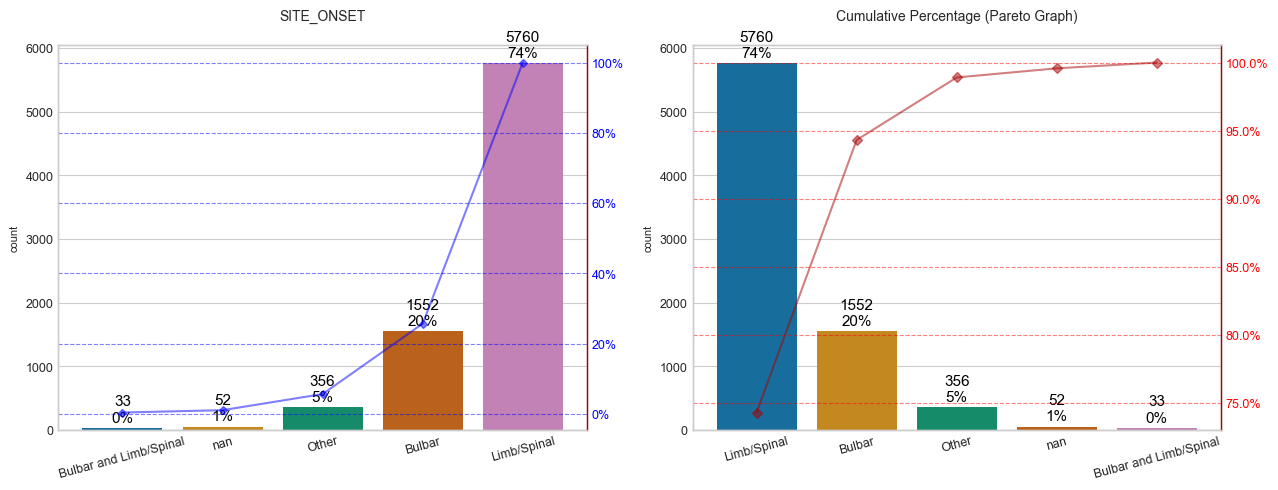


Removing samples...
  -  Previous=7753, To delete=52, After=7701
Column Site_Onset  (7701 rows)   (DataType: object)


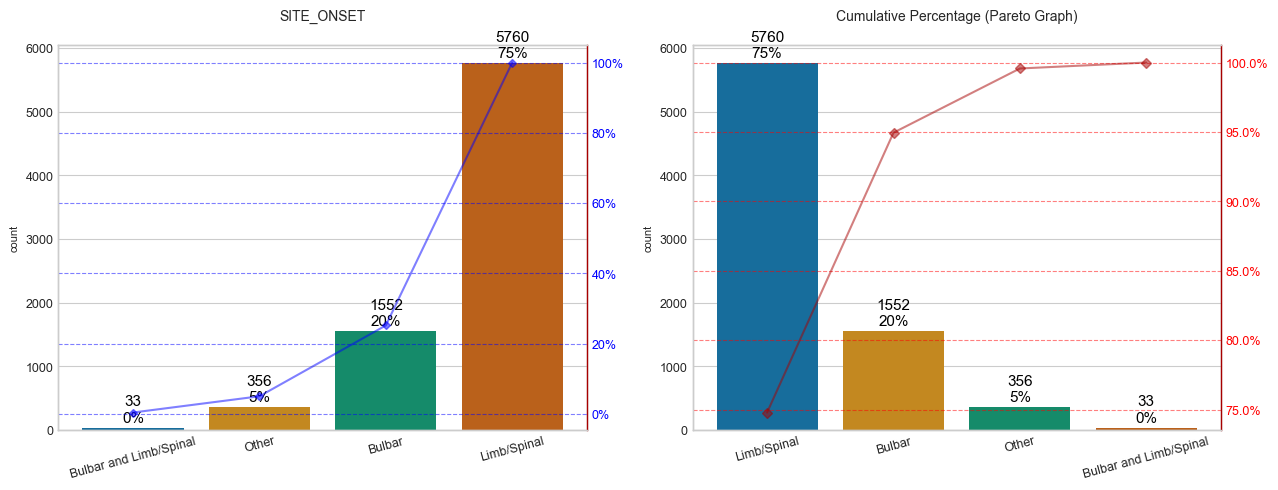

In [37]:
utils.plot_variable_distribution(series=df.Site_Onset, print_more_info=False)

print()
print('Removing samples...')
# remove samples
to_delete = df.loc[
     (df.Site_Onset=='nan')
]
df_survival = utils.remove_rows(df=df, to_delete=to_delete)

utils.plot_variable_distribution(series=df_survival.Site_Onset, print_more_info=False)

df = df_survival

## Get quantity of measurements for each patient, and save them.

In [38]:
df_patients = df.copy()
df_measurements = df_patients[['subject_id']]

csv_files = [
    ['ALSFRS', '../03_preprocessed_data/TimeSeries/ALSFRS/ALSFRS_TimeSeries_Q1_Speech_RAW.csv'],
    ['FVC', '../03_preprocessed_data/TimeSeries/First_Visit_FVC_TimeSeries_RAW.csv'],
    ['SVC', '../03_preprocessed_data/TimeSeries/First_Visit_SVC_TimeSeries_RAW.csv'],
    ['BMI', '../03_preprocessed_data/TimeSeries/First_Visit_BMI_TimeSeries_RAW.csv'],
]

for biomarker, csv_file in csv_files:

    df_qty = utils.read_csv(csv_file=csv_file)

    col_qty = f'Qty_Measurements_{biomarker}'

    # count values non NaN not including subject_id (i.e., column[0])
    df_qty[col_qty] = df_qty[df_qty.columns[1:]].count(axis=1)

    df_qty = df_qty[['subject_id', col_qty]]

    df_measurements = utils.join_datasets_by_key(
        df_main=df_measurements, 
        df_to_join=df_qty, 
        key_name='subject_id', 
        how='left'
    )


    # fill NaN values with 0
    df_measurements.fillna(0, inplace=True)
    # convert to int
    df_measurements[col_qty] = df_measurements[col_qty].astype(int)


# # save qty of measurements by patient
# csv_dest = f'{dir_dest}/patient_measurements.csv'
# utils.save_to_csv(df=df_measurements, csv_file=csv_dest)

# # display(df_measurements)


# save patients data inserting qt of measurements
df_patients = utils.join_datasets_by_key(
    df_main=df_patients, 
    df_to_join=df_measurements, 
    key_name='subject_id', 
    how='left'
)

dir_dest = os.path.abspath('../03_preprocessed_data/')
csv_dest = f'{dir_dest}/patient.csv'
utils.save_to_csv(df=df_patients, csv_file=csv_dest)

df_patients


7701 samples were saved


,subject_id,Age,Sex,Symptoms_Onset_Delta,Site_Onset,Age_at_Onset,Last_Visit_from_First_Visit,Last_Visit_from_Onset,Event_Dead,Event_Dead_Time_from_Onset,Event_Dead_Time_from_First_Visit,Riluzole,Qty_Measurements_ALSFRS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_BMI
1,329,38.0,Female,-1706.0,Limb/Spinal,34.0,9.0,65.0,False,65.0,9.0,False,10,7,0,10
2,348,52.0,Female,-501.0,Other,51.0,13.0,29.0,False,29.0,13.0,True,14,0,8,7
5,533,65.0,Female,-1023.0,Bulbar,63.0,13.0,46.0,False,46.0,13.0,False,5,1,0,6
6,586,63.0,Male,-715.0,Bulbar,61.0,0.0,23.0,False,23.0,0.0,False,1,1,0,1
7,649,48.0,Female,-341.0,Bulbar,47.0,18.0,29.0,False,29.0,18.0,True,11,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11670,22564,63.0,Male,-426.0,Limb/Spinal,62.0,3.0,17.0,False,17.0,3.0,True,4,0,3,0
11671,160135,67.0,Female,-651.0,Bulbar,66.0,4.0,25.0,False,25.0,4.0,False,5,0,3,0
11672,304192,59.0,Female,-838.0,Limb/Spinal,57.0,4.0,31.0,False,31.0,4.0,False,5,0,4,0
11673,820199,49.0,Male,-155.0,Limb/Spinal,49.0,4.0,9.0,False,9.0,4.0,False,5,0,4,0


## Print total of patients having 3 or more visits according to the features used

In [39]:
cols = [
    'Qty_Measurements_FVC',
    'Qty_Measurements_BMI',
    'Qty_Measurements_ALSFRS',
    'Qty_Measurements_SVC',
]

min_measurements = 3

df_measurements = df_patients.copy()

df_plot = df_measurements.loc[
    (df_measurements[cols[0]] >= min_measurements)
]
print(f'Qtd FVC    > 3: *{df_plot.shape[0]} pacientes*')

df_plot = df_measurements.loc[
    (df_measurements[cols[1]] >= min_measurements)
]
print(f'Qtd BMI    > 3: *{df_plot.shape[0]} pacientes*')

df_plot = df_measurements.loc[
    (df_measurements[cols[2]] >= min_measurements)
]
print(f'Qtd ALSFRS > 3: *{df_plot.shape[0]} pacientes*')


df_plot = df_measurements.loc[
    (df_measurements[cols[3]] >= min_measurements)
]
print(f'Qtd SVC.   > 3: *{df_plot.shape[0]} pacientes*')
print()



df_plot = df_measurements.loc[
    (df_measurements[cols[0]] >= min_measurements)
    &(df_measurements[cols[1]] >= min_measurements)
    &(df_measurements[cols[2]] >= min_measurements)
    &(df_measurements[cols[3]] >= min_measurements)
]
print(f'Usando as FVC + SVC + BMI + ALSFRS: *{df_plot.shape[0]} pacientes*')
print()
      
df_plot = df_measurements.loc[
    (df_measurements[cols[0]] >= min_measurements)
    &(df_measurements[cols[1]] >= min_measurements)
    &(df_measurements[cols[2]] >= min_measurements)
]
print(f'Usando as FVC + BMI + ALSFRS: *{df_plot.shape[0]} pacientes*')
print()
      

df_plot = df_measurements.loc[
    (df_measurements[cols[0]] >= min_measurements)
#     &(df_measurements[cols[1]] >= min_measurements)
    &(df_measurements[cols[2]] >= min_measurements)
]
print(f'Usando as FVC + ALSFRS: *{df_plot.shape[0]} pacientes*')
print()

df_plot = df_measurements.loc[
#     (df_measurements[cols[0]] >= min_measurements)
    (df_measurements[cols[1]] >= min_measurements)
    &(df_measurements[cols[2]] >= min_measurements)
]
print(f'Usando as BMI + ALSFRS: *{df_plot.shape[0]} pacientes*')
print()


df_plot = df_measurements.loc[
#     (df_measurements[cols[0]] >= min_measurements)
#     &(df_measurements[cols[1]] >= min_measurements)
    (df_measurements[cols[2]] >= min_measurements)
]

print(f'Usando só ALSFRS: *{df_plot.shape[0]} pacientes*')
print()


Qtd FVC    > 3: *2695 pacientes*
Qtd BMI    > 3: *5024 pacientes*
Qtd ALSFRS > 3: *6506 pacientes*
Qtd SVC.   > 3: *1145 pacientes*

Usando as FVC + SVC + BMI + ALSFRS: *0 pacientes*

Usando as FVC + BMI + ALSFRS: *1866 pacientes*

Usando as FVC + ALSFRS: *2680 pacientes*

Usando as BMI + ALSFRS: *4858 pacientes*

Usando só ALSFRS: *6506 pacientes*



# 21. Get and Save patients having >= 3 visits for ALSFRS, and having at least  15 months of visit information

In [40]:
df_alsfrs = utils.read_csv('../03_preprocessed_data/TimeSeries/ALSFRS/ALSFRS_TimeSeries_Q1_Speech_RAW.csv')

months_with_data = [
#     12, 
    15,
]

csvs_generated = []

for month in months_with_data:
    df_patients_to_analyze = utils_preprocessing.get_first_last_visits(
        df_patients=df_patients, 
        df_alsfrs=df_alsfrs, 
        max_months_to_analyze=month,
    )

    # save
    dir_dest = os.path.abspath('../04_data_to_analyze/')
    csv_name_base = f'patient_having_{month}m_data'
    csv_dest = f'{dir_dest}/{csv_name_base}.csv'
    utils.save_to_csv(df=df_patients_to_analyze, csv_file=csv_dest)
    csvs_generated.append(csv_dest)
    
    # codify categoric columns and save the coded data
    df_coded = utils_preprocessing.perform_data_codification(df_patients=df_patients_to_analyze)
    csv_dest = f'{dir_dest}/{csv_name_base}_coded.csv'
    utils.save_to_csv(df=df_coded, csv_file=csv_dest)    


1769 samples were saved
1769 samples were saved


---
---
# Generate Timeseries dataset, adding info about the $static$ features

In [41]:
data_dir = '../03_preprocessed_data'

ts_data_dir = f'{data_dir}/TimeSeries/ALSFRS/'

csv_prefix = 'ALSFRS_TimeSeries_'

features = [
    'Q1_Speech',
    'Q2_Salivation',
    'Q3_Swallowing',
    'Q4_Handwriting',
    'Q5_Cutting',
    'Q6_Dressing_and_Hygiene',
    'Q7_Turning_in_Bed',
    'Q8_Walking',
    'Q9_Climbing_Stairs',
    'Q10_Respiratory',
    #
    'ALSFRS_Total',
    #
    'Qty_Regions_Involved',
    'Region_Involved_Bulbar',
    'Region_Involved_Lower_Limb',
    'Region_Involved_Upper_Limb',
    'Region_Involved_Respiratory',
    #
    'Patient_with_Gastrostomy',
    #
    'Disease_Duration',

]

patients_cols = [
    'subject_id',
    'Sex_Male',
    'Site_Onset',
    'Age_at_Onset',
    'Riluzole',
]

for csv_generated in csvs_generated:
    
    month_data_info = csv_generated.split('_having_')[1].replace('.csv', '')

    # get subject_ids
    df_to_filter = utils.read_csv(csv_generated)
    subject_ids_to_filter = df_to_filter.subject_id.unique()
    
    # GET PATIENT DATA
    df_patients = utils.read_csv(os.path.abspath(f'../04_data_to_analyze/patient_having_{month_data_info}_coded.csv'))
    df_patients = df_patients[patients_cols]
    df_patients.dropna(inplace=True)
                                                 
    subject_ids_to_filter = df_patients.subject_id.unique()
    
    # create time series dataset joining all features into a single csv
    df_time_series = None
    for feature in features:

        # read INTERPOLATED data using first visit as a baseline
        ts_file = f'{ts_data_dir}/{csv_prefix}{feature}.csv'
        df_ts = utils.read_csv(csv_file=f'{ts_file}')
        
        # filter by subject_ids
        df_ts = df_ts.loc[(df_ts.subject_id.isin(subject_ids_to_filter))].copy()

        df_ts.sort_values(by=['subject_id'], inplace=True)
        df_ts.insert(1, 'feature', feature)

        if df_time_series is None:
            df_time_series = df_ts
        else:
            df_time_series = pd.concat([df_time_series, df_ts], ignore_index=True)
        
        
    print(csv_generated)
    print(len(df_time_series.subject_id.unique()))
#     display(df_time_series)
    
    # generate static features as time series using the last df_ts generated
    df_static_as_ts = utils_time_series_generation.generate_time_series_static_features_based_on_alsfrs(
        df_temporal=df_ts,
        df_patients=df_patients,
    )

    # join temporal features with static
    df_time_series = pd.concat([df_time_series, df_static_as_ts], ignore_index=True)
    
    # save data-as-time-series into CSV
    dir_dest = os.path.abspath('../05_data_as_time_series')
    csv_dest = f'{dir_dest}/data_as_time_series_{month_data_info}_Only_ALSFRS.csv'
    utils.save_to_csv(df=df_time_series, csv_file=csv_dest)

#     display(df_static_as_ts)
    
#     del df_ts, df_time_series, df_static_as_ts  
    
    
    

/home/papaiz/Lixo/autoregressive/04_data_to_analyze/patient_having_15m_data.csv
1756
Index(['subject_id', 'Sex_Male', 'Site_Onset', 'Age_at_Onset', 'Riluzole'], dtype='object')
subject_id
Sex_Male
Site_Onset
Age_at_Onset
Riluzole


/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1007: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_aux[str(month)] = df_aux[column].copy()
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1007: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_aux[str(month)] = df_aux[column].copy()
/home/papaiz/Lixo/autoregressive/02_ETL/../utils_time_series_generation.py:1007: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

38632 samples were saved


---
---
---
# OTHERS
---
---
---